In [4]:
import numpy as np
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

from run_realization_v2 import setup_submit_wait
from DA_operators import operator_clm_SMAP, operator_clm_FLX

import multiprocessing as mp

from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time
import sys
import pickle
from helpers import save_dict_to_pickle, load_dict_from_pickle

folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2'
if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
from settings_copy import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

dir_figs = os.path.join(folder_results,'figures/02_gridded_SMAP_mismatch')
if not os.path.exists(dir_figs):
    print('Creating folder to store gridded SMAP mismatch: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
pickle_filename = os.path.join(dir_figs,'gridded_mismatch.pickle')


In [2]:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]
date_end_sim = date_results_binned[i_date][-1][-1]

# for the plots include the validation timespan
date_validation_start = date_results_iter[-1][-1]
date_results_iter.append(list(date_range_noleap(date_validation_start,
                                                date_validation_start+timedelta(days=settings_run['ndays_validation']),freq=freq_output)))



In [ ]:
## Only run when dict is not available!!! 

operator = {}
data_measured = {}
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
_ = operator['SMAP'].get_measurements(date_results_iter,date_DA_start=date_start_sim)
# operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
# _ = operator['FLX'].get_measurements(date_results_iter,date_DA_start=date_start_sim)

loc_array_2d = np.array([operator['SMAP'].grid_TSMP.lat_centre.values,operator['SMAP'].grid_TSMP.lon_centre.values])

results = {}
for i_real in [0,52]:
    results[i_real] = {}
    _ = operator['SMAP'].interpolate_model_results(i_real,settings_run,indices_z=[0,1],var='SOILLIQ')

    daily_diff = np.nan*np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])
    n_obs = np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])

    for i_date,date_ in enumerate(list(operator['SMAP'].sm_out.keys())):
        # i_date = 0
        # date_ = list(operator['SMAP'].sm_out.keys())[0]
        print(date_)

        diff = operator['SMAP'].sm_out[date_] - operator['SMAP'].data_TSMP_i[date_] 

        for i1,(lat_,lon_,diff_) in enumerate(zip(operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_],diff)):
            # lat_ = operator['SMAP'].lats_out[date_][0]
            # lon_ = operator['SMAP'].lons_out[date_][0]
            dist = haversine_distance_2d(np.array([lat_,lon_]).T,loc_array_2d)

            i_min = np.unravel_index(dist.argmin(), dist.shape)

            daily_diff[i_date,i_min[0],i_min[1]] = diff_
            n_obs[i_date,i_min[0],i_min[1]] += 1

            if i1%5000 == 0:
                print('%i/%i' % (i1,len(operator['SMAP'].lats_out[date_])))

    results[i_real]['dates'] = list(operator['SMAP'].sm_out.keys())
    results[i_real]['daily_diff'] = daily_diff
    results[i_real]['n_obs'] = n_obs
    
save_dict_to_pickle(results,pickle_filename)

In [7]:
results = load_dict_from_pickle(pickle_filename)
results.keys()

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/figures/02_gridded_SMAP_mismatch/gridded_mismatch.pickle


dict_keys([0, 52])

In [ ]:
i_real = 0

dates = np.array(results[i_real]['dates'])
diff_max = 0.4

str_date1 = str(results[i_real]['dates'][0])[0:10]
str_date2 = str(results[i_real]['dates'][-1])[0:10]
plt.figure()
plt.pcolormesh(operator['SMAP'].grid_TSMP['lon_corner'],operator['SMAP'].grid_TSMP['lat_corner'],operator['SMAP'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )

plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
               np.nanmean(results[i_real]['daily_diff'],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
cbar = plt.colorbar(extend='both')
cbar.set_label('SMAP - TSMP [mm3/mm3]')
plt.title('Mean mismatch between %s - %s' % (str_date1,str_date2 ) )
plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )


In [3]:
# which data to assimilate: 
data_names = settings_DA['data_names']
# If uncertainties are assumed constant, prescribe:
data_var = {'SMAP':0.04**2,
            'FLX':None}
# possibility to only select a limited amount of observations using masks
data_nselect = settings_DA['n_data_max']
data_mask = {'SMAP':None, #initialize dict
             'FLX':None}
plot_members_SMAP = 0 #set to int (iteration for which to plot members), or to False/True
plot_members_FLX = True

# prescribe_alpha = settings_DA['prescribe_alpha']
alpha = settings_DA['alpha']
factor_inflate = settings_DA['factor_inflate']
factor_inflate_prior = settings_DA['factor_inflate_prior']
ksi=settings_DA['cutoff_svd']

### Unpack some of the settings into variables
# Functions that are run to initialize the parameters to be assimilated. 
# E.g. for spatial parameter fields, initialize the static fields (x,y,z) locations and the prior/uncertainty estimates
param_setup = settings_DA['param_setup'] 
# Functions that are run to generate realizations of parameters/state variables
param_gen   = settings_DA['param_gen']
# Define parameter names; parameters values are stored in (%s.param.npy % param_name) files
param_names = settings_DA['param_names']

n_parallel = settings_DA['n_parallel']
n_parallel_setup = settings_DA['n_parallel_setup']
n_ensemble = settings_DA['n_ensemble']
n_iter = settings_DA['n_iter']
dir_setup = settings_run['dir_setup']
dir_template = settings_run['dir_template']


# Read parameter length and put in dictionary here
for param_ in param_names:
    settings_gen['param_length'][param_] = np.load(os.path.join(dir_DA,'%s.param.000.000.prior.npy' % param_) ).shape[0]

#%% ----------- DA loop -----------


#%% ----------- date loop -----------    
# this comes in the date loop, e.g. perform the smoother over a period over 1 year:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)

# add spinup if necessary:
if settings_run['ndays_spinup'] is not None:
    date_results_iter.insert(0,list(date_range_noleap(date_start_sim-timedelta(days=settings_run['ndays_spinup']),date_start_sim,periods=2)))


str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)
if not os.path.exists(dir_date):
    print('Creating folder for dates %s: %s' % (str_date,dir_date) )
    os.mkdir(dir_date)

## TEMP
# date_DA_start = date_end_sim - timedelta(days=30) # spinup, only assimilate last 30 days
# date_DA_start = datetime(2019,1,1,12,0,0)

mismatch_iter = [0]
i_iter = 3
str_iter = 'i%3.3i' % i_iter
dir_iter = os.path.join(dir_date,str_iter)


if settings_run['ndays_validation'] is not None:
    date_validation_start = date_results_iter[-1][-1]
    date_results_iter.append(list(date_range_noleap(date_validation_start,
                                                    date_validation_start+timedelta(days=settings_run['ndays_validation']),freq=freq_output)))
    print('Last iteration: running most likely parameter values and the OL run, including validation timespan: %s-%s'
      %(str(date_end_sim),str(date_end_sim+timedelta(days=settings_run['ndays_validation']))) )
else:
    print('Last iteration: running most likely parameter values and the OL run')

settings_run['dir_iter'] = dir_iter
settings_gen['i_date'] = i_date
settings_gen['i_iter'] = i_iter
settings_gen['param_gen'] = param_gen
settings_gen['param_names'] = param_names
settings_clm['vars_dump'] = settings_clm['vars_dump_val']


operator = {}
data_measured = {}
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
_ = operator['SMAP'].get_measurements(date_results_iter,date_DA_start=date_start_sim)
# operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
# _ = operator['FLX'].get_measurements(date_results_iter,date_DA_start=date_start_sim)

loc_array_2d = np.array([operator['SMAP'].grid_TSMP.lat_centre.values,operator['SMAP'].grid_TSMP.lon_centre.values])



Continuing simulation in /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2
Last iteration: running most likely parameter values and the OL run, including validation timespan: 2019-07-30 20:00:00-2020-07-24 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-21 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-24 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-27 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-30 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-03 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-06 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-07-24 12:00:00, TSMP: 

In [ ]:
results = {}

# i_real = 0
for i_real in [0,52]:
    results[i_real] = {}
    _ = operator['SMAP'].interpolate_model_results(i_real,settings_run,indices_z=[0,1],var='SOILLIQ')

    daily_diff = np.nan*np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])
    n_obs = np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])

    for i_date,date_ in enumerate(list(operator['SMAP'].sm_out.keys())):
        # i_date = 0
        # date_ = list(operator['SMAP'].sm_out.keys())[0]
        print(date_)

        diff = operator['SMAP'].sm_out[date_] - operator['SMAP'].data_TSMP_i[date_] 

        for i1,(lat_,lon_,diff_) in enumerate(zip(operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_],diff)):
            # lat_ = operator['SMAP'].lats_out[date_][0]
            # lon_ = operator['SMAP'].lons_out[date_][0]
            dist = haversine_distance_2d(np.array([lat_,lon_]).T,loc_array_2d)

            i_min = np.unravel_index(dist.argmin(), dist.shape)

            daily_diff[i_date,i_min[0],i_min[1]] = diff_
            n_obs[i_date,i_min[0],i_min[1]] += 1

            if i1%5000 == 0:
                print('%i/%i' % (i1,len(operator['SMAP'].lats_out[date_])))

    results[i_real]['dates'] = list(operator['SMAP'].sm_out.keys())
    results[i_real]['daily_diff'] = daily_diff
    results[i_real]['n_obs'] = n_obs
    
save_dict_to_pickle(results,pickle_filename)

In [22]:
results[i_real]['dates'] = list(operator['SMAP'].sm_out.keys())
results[i_real]['daily_diff'] = daily_diff
results[i_real]['n_obs'] = n_obs
save_dict_to_pickle(results,pickle_filename)


Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/figures/02_gridded_SMAP_mismatch/gridded_mismatch.pickle


In [7]:
pickle_filename = os.path.join(dir_figs,'gridded_mismatch.pickle')

results = load_dict_from_pickle(pickle_filename)

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/figures/02_gridded_SMAP_mismatch/gridded_mismatch.pickle


In [20]:
(operator['SMAP'].grid_TSMP['lsm']==2).values

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [21]:
dir_figs

grid = {}
grid['background'] = (operator['SMAP'].grid_TSMP['lsm']==2).values
grid['lat_c'] = operator['SMAP'].grid_TSMP['lat_corner'].values
grid['lon_c'] = operator['SMAP'].grid_TSMP['lon_corner'].values

save_dict_to_pickle(grid,os.path.join(dir_figs,'grid.pickle'))


Dictionary saved to /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2/figures/02_gridded_SMAP_mismatch/grid.pickle


/tmp/ipykernel_21226/2841276605.py:13: RuntimeWarning: Mean of empty slice
  np.nanmean(results[i_real]['daily_diff'],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)


Text(0.5, 1.0, 'Mean mismatch between 2019-05-01 - 2020-07-22')

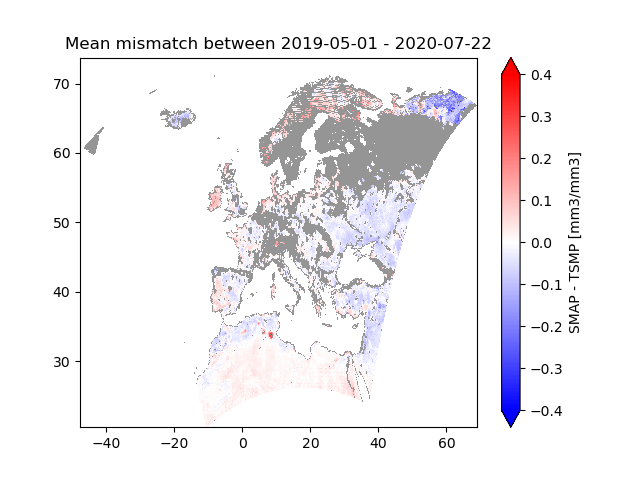

In [11]:
i_real = 0
%matplotlib widget

dates = np.array(results[i_real]['dates'])
diff_max = 0.4

str_date1 = str(results[i_real]['dates'][0])[0:10]
str_date2 = str(results[i_real]['dates'][-1])[0:10]
plt.figure()
plt.pcolormesh(operator['SMAP'].grid_TSMP['lon_corner'],operator['SMAP'].grid_TSMP['lat_corner'],operator['SMAP'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )

plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
               np.nanmean(results[i_real]['daily_diff'],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
cbar = plt.colorbar(extend='both')
cbar.set_label('SMAP - TSMP [mm3/mm3]')
plt.title('Mean mismatch between %s - %s' % (str_date1,str_date2 ) )

/tmp/ipykernel_6465/2336292793.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(results[i_real]['daily_diff'],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
/tmp/ipykernel_6465/2336292793.py:44: RuntimeWarning: Mean of empty slice
  np.nanmean(results[i_real]['daily_diff'][i_train_start:i_train_end,:,:],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
/tmp/ipykernel_6465/2336292793.py:69: RuntimeWarning: Mean of empty slice
  np.nanmean(results[i_real]['daily_diff'][i_val_start:i_val_end,:,:],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)


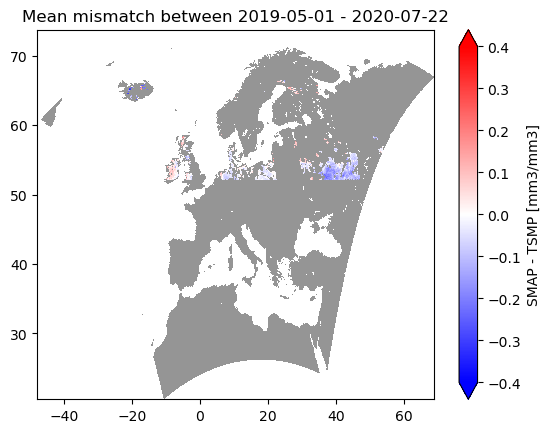

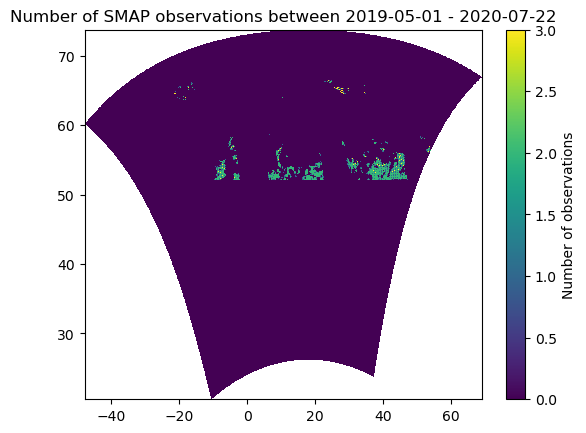

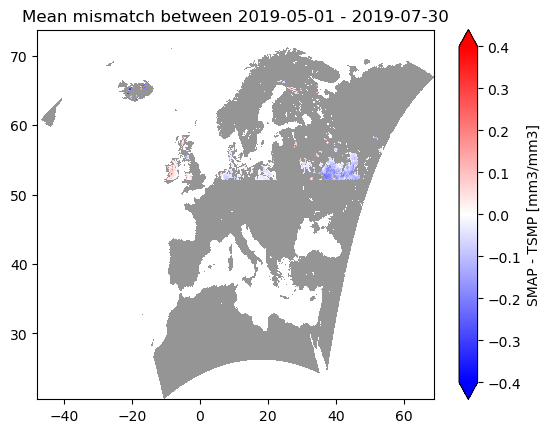

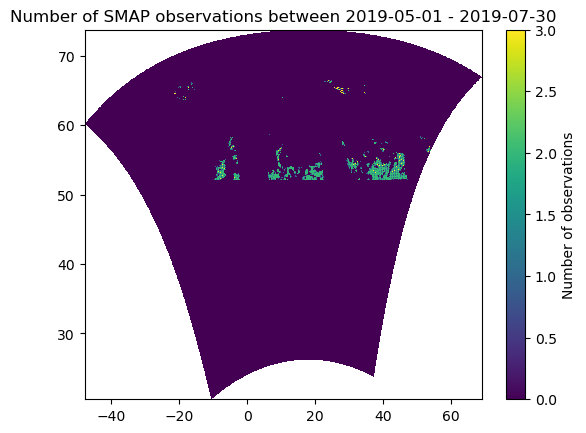

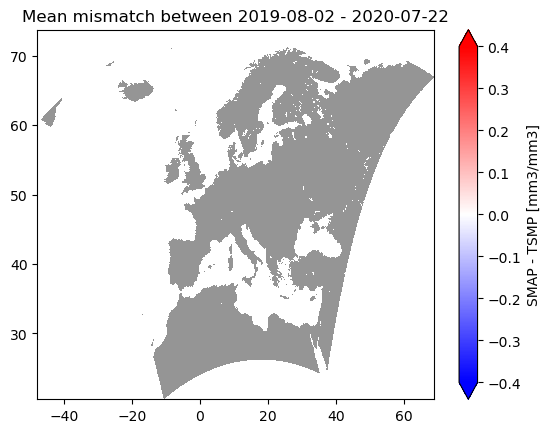

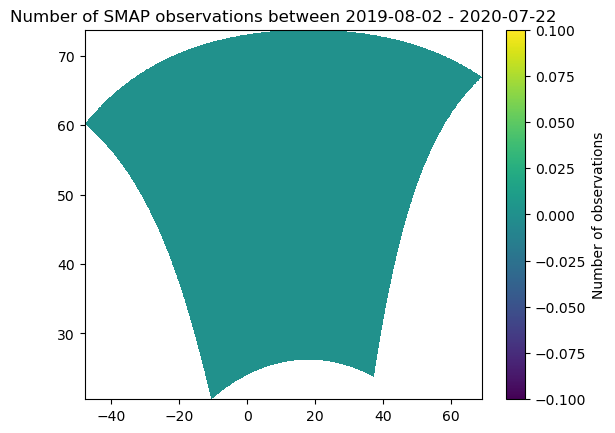

In [70]:
%matplotlib inline


for i_real in results.keys():
    dates = np.array(results[i_real]['dates'])
    diff_max = 0.4

    str_date1 = str(results[i_real]['dates'][0])[0:10]
    str_date2 = str(results[i_real]['dates'][-1])[0:10]
    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP['lon_corner'],operator['SMAP'].grid_TSMP['lat_corner'],operator['SMAP'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )

    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   np.nanmean(results[i_real]['daily_diff'],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
    cbar = plt.colorbar(extend='both')
    cbar.set_label('SMAP - TSMP [mm3/mm3]')
    plt.title('Mean mismatch between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )


    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   results[i_real]['n_obs'].sum(axis=0),cmap=plt.cm.viridis)
    cbar = plt.colorbar()
    cbar.set_label('Number of observations')
    plt.title('Number of SMAP observations between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )

    i_train_start = 0
    i_train_end = np.where(dates == date_results_iter[1][-1])[0][0] + 1
    
    i_val_start = i_train_end 
    i_val_end = -1
    
    
    str_date1 = str(results[i_real]['dates'][i_train_start])[0:10]
    str_date2 = str(results[i_real]['dates'][i_train_end-1])[0:10]    
    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP['lon_corner'],operator['SMAP'].grid_TSMP['lat_corner'],operator['SMAP'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )

    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   np.nanmean(results[i_real]['daily_diff'][i_train_start:i_train_end,:,:],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
    cbar = plt.colorbar(extend='both')
    cbar.set_label('SMAP - TSMP [mm3/mm3]')
    plt.title('Mean mismatch between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )


    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   results[i_real]['n_obs'][i_train_start:i_train_end,:,:].sum(axis=0),cmap=plt.cm.viridis)
    cbar = plt.colorbar()
    cbar.set_label('Number of observations')
    plt.title('Number of SMAP observations between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )
    
    
    
    str_date1 = str(results[i_real]['dates'][i_val_start])[0:10]
    str_date2 = str(results[i_real]['dates'][i_val_end])[0:10]    
    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP['lon_corner'],operator['SMAP'].grid_TSMP['lat_corner'],operator['SMAP'].grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )

    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   np.nanmean(results[i_real]['daily_diff'][i_val_start:i_val_end,:,:],axis=0),cmap=plt.cm.bwr,vmin=-diff_max,vmax=diff_max)
    cbar = plt.colorbar(extend='both')
    cbar.set_label('SMAP - TSMP [mm3/mm3]')
    plt.title('Mean mismatch between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'mean_mismatch_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )


    plt.figure()
    plt.pcolormesh(operator['SMAP'].grid_TSMP.lon_corner,operator['SMAP'].grid_TSMP.lat_corner,
                   results[i_real]['n_obs'][i_val_start:i_val_end,:,:].sum(axis=0),cmap=plt.cm.viridis)
    cbar = plt.colorbar()
    cbar.set_label('Number of observations')
    plt.title('Number of SMAP observations between %s - %s' % (str_date1,str_date2 ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.pdf'%(str_date1,str_date2,i_real) ) )
    # plt.savefig(os.path.join(dir_figs,'nobs_%s_%s_%3.3i.png'%(str_date1,str_date2,i_real) ) )    

In [68]:
str(results[i_real]['dates'][i_train_end-1])[0:10]    

'2019-07-30'

In [165]:
operator['SMAP'].grid_TSMP.lon_centre.values.ravel()
operator['SMAP'].grid_TSMP.lat_centre.values.ravel().shape
operator['SMAP'].lons_out[date_].shape

loc_array = np.array([operator['SMAP'].grid_TSMP.lat_centre.values.ravel(),operator['SMAP'].grid_TSMP.lon_centre.values.ravel()]).T
loc_array_2d = np.array([operator['SMAP'].grid_TSMP.lat_centre.values,operator['SMAP'].grid_TSMP.lon_centre.values])

loc1_array = np.array([operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_]]).T
# loc array shapes: n x 2
# distances = haversine_distance_vec(loc1_array, loc_array)

In [166]:
loc_array_2d.shape

(2, 432, 444)

In [122]:
operator['SMAP'].grid_TSMP.lat_centre.shape

(432, 444)

In [167]:
loc_array_2d = np.array([operator['SMAP'].grid_TSMP.lat_centre.values,operator['SMAP'].grid_TSMP.lon_centre.values])
results = {}
results[i_real] = {}

daily_diff = np.nan*np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])
n_obs = np.zeros([len(operator['SMAP'].lats_out.keys()),operator['SMAP'].grid_TSMP.lat_centre.shape[0],operator['SMAP'].grid_TSMP.lat_centre.shape[1]])

# for i_date,date_ in enumerate(list(operator['SMAP'].sm_out.keys())):
i_date = 0
date_ = list(operator['SMAP'].sm_out.keys())[0]
print(date_)

diff = operator['SMAP'].sm_out[date_] - operator['SMAP'].data_TSMP_i[date_] 

for i1,(lat_,lon_,diff_) in enumerate(zip(operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_],diff)):
    # lat_ = operator['SMAP'].lats_out[date_][0]
    # lon_ = operator['SMAP'].lons_out[date_][0]
    dist = haversine_distance_2d(np.array([lat_,lon_]).T,loc_array_2d)

    i_min = np.unravel_index(dist.argmin(), dist.shape)

    daily_diff[i_date,i_min[0],i_min[1]] = diff_
    n_obs[i_date,i_min[0],i_min[1]] += 1

    if i1%5000 == 0:
        print('%i/%i' % (i1,len(operator['SMAP'].lats_out[date_])))
        
results[i_real]['daily_diff'] = daily_diff
results[i_real]['n_obs'] = n_obs

save_dict_to_pickle(results,pickle_filename)


0/50514
1000/50514
2000/50514
3000/50514
4000/50514
5000/50514
6000/50514
7000/50514
8000/50514
9000/50514
10000/50514
11000/50514
12000/50514
13000/50514
14000/50514
15000/50514
16000/50514
17000/50514
18000/50514
19000/50514
20000/50514
21000/50514
22000/50514
23000/50514
24000/50514
25000/50514
26000/50514
27000/50514
28000/50514
29000/50514
30000/50514
31000/50514
32000/50514
33000/50514
34000/50514
35000/50514
36000/50514
37000/50514
38000/50514
39000/50514
40000/50514
41000/50514
42000/50514
43000/50514
44000/50514
45000/50514
46000/50514
47000/50514
48000/50514
49000/50514
50000/50514


0.20168423056602477

In [164]:
def haversine_distance_2d(loc1, loc_array):
    """
    Calculate the Haversine distance between a point and an array of points on the Earth
    given their latitude and longitude in decimal degrees.

    Parameters:
    - loc1: Tuple containing the latitude and longitude of the first point (in decimal degrees).
    - loc_array: 2D arrays with latitudes and longitudes of points (in decimal degrees).

    Returns:
    - Array of distances between loc1 and each point in loc_array (in kilometers).
    """
    if np.isnan(loc1[0]) and np.isnan(loc1[1]):
        distances = np.zeros(loc_array.shape[0])
    else:
        # Radius of the Earth in kilometers
        R = 6371.0

        # Convert decimal degrees to radians
        lat1_rad, lon1_rad = np.radians(loc1)
        lat2_rad, lon2_rad = np.radians(loc_array[0,:,:]), np.radians(loc_array[1,:,:])

        # Haversine formula
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad

        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distances = R * c
    return distances

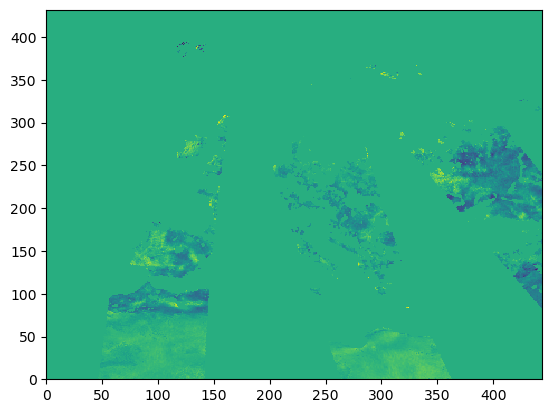

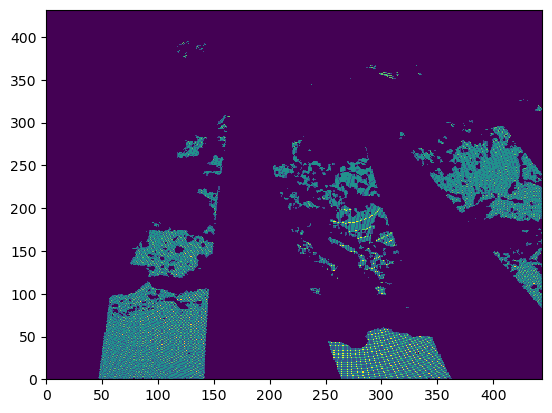

In [161]:
dist.shape

(444, 432)

In [152]:
operator['SMAP'].lats_out[date_].shape

(50514,)

In [145]:
i_min = np.unravel_index(dist.argmin(), dist.shape)
loc_array_2d[i_min]

array([66.43916 , 23.846323], dtype=float32)

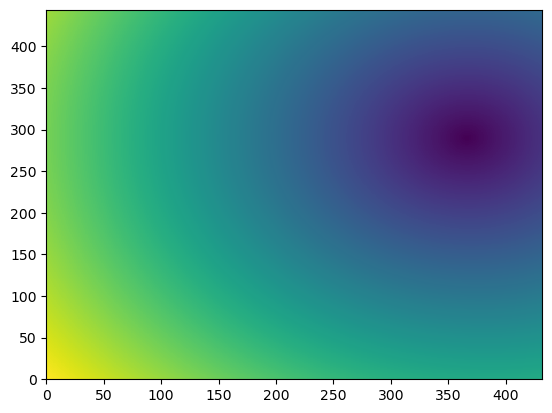

In [143]:
plt.figure()
plt.pcolormesh(dist)

In [125]:
loc_array.shape

(191808, 2)

In [117]:
np.argmin(dist)
print(lat_,lon_,loc_array[np.argmin(dist),:])

66.42348 23.760374 [66.43916  23.846323]


In [95]:
sm_i.reshape(operator['SMAP'].grid_TSMP.lon_centre.shape)
# operator['SMAP'].grid_TSMP.lon_centre.shape

array([[0.04602011, 0.04602011, 0.04602011, ..., 0.05661422, 0.05661422,
        0.05661422],
       [0.04602011, 0.04602011, 0.04602011, ..., 0.05661422, 0.05661422,
        0.05661422],
       [0.04602011, 0.04602011, 0.04602011, ..., 0.05661422, 0.05661422,
        0.05661422],
       ...,
       [0.22547153, 0.22547153, 0.22547153, ..., 0.27129918, 0.27129918,
        0.27129918],
       [0.22547153, 0.22547153, 0.22547153, ..., 0.27129918, 0.27129918,
        0.27129918],
       [0.22547153, 0.22547153, 0.22547153, ..., 0.27129918, 0.27129918,
        0.27129918]], dtype=float32)

In [104]:
from scipy.interpolate import griddata

# griddata((np.concatenate((self.grid_TSMP.lon_centre.values.ravel(),self.grid_TSMP.lon_edges)),
#           np.concatenate((self.grid_TSMP.lat_centre.values.ravel(),self.grid_TSMP.lat_edges))),
#                                                  np.concatenate((self.grid_TSMP.lsm.values.ravel(),self.grid_TSMP.lsm_edges)),
#                                                  (lons,lats),method='nearest') == 2

sm_i = griddata((operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_]),
         operator['SMAP'].sm_out[date_],
         (operator['SMAP'].grid_TSMP.lat_centre.values.ravel(),operator['SMAP'].grid_TSMP.lon_centre.values.ravel()),method='nearest')

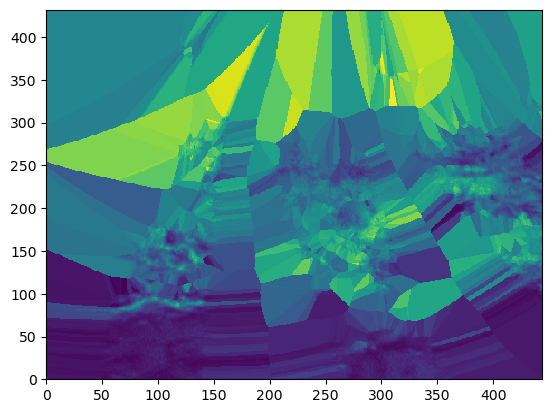

In [97]:
%matplotlib inline
plt.figure()
plt.pcolormesh(sm_i.reshape(operator['SMAP'].grid_TSMP.lon_centre.shape))

In [101]:
(operator['SMAP'].grid_TSMP.lsm==2).sum()

<xarray.DataArray 'lsm' ()>
array(103152)

In [61]:
diff = operator['SMAP'].sm_out[date_] - operator['SMAP'].data_TSMP_i[date_] 

In [71]:
operator['SMAP'].grid_TSMP.lat_centre.values.ravel()

array([20.576464, 20.617147, 20.657703, ..., 67.033775, 66.96811 ,
       66.90226 ], dtype=float32)

In [74]:
np.array([operator['SMAP'].lats_out[date_],operator['SMAP'].lons_out[date_]]).T.shape

(50514, 2)

In [83]:
loc1_array.shape

(50514, 2)

In [84]:
%timeit haversine_distance(loc1_array[0,:], loc_array)

5.19 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
50000*5e-3

250.0

In [89]:
(250/60/60)*(365/3)

8.449074074074074

In [22]:
pwd

'/p/project/cjibg36/kaandorp2/Git/TSMP_DA/Ks_DA'

In [23]:
cd /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_3m_POL08/figures/validation

/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_3m_POL08/figures/validation


In [26]:
utils 

NameError: name 'utils' is not defined